In [2]:
import pandas as pd

# Load JSON with line-delimited format
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df = df[["headline", "is_sarcastic"]]
df.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [3]:
from sklearn.model_selection import train_test_split

# Basic cleaning (optional)
df["headline"] = df["headline"].str.lower()

# Train-val-test split
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["is_sarcastic"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["is_sarcastic"])

print(train_df.shape, val_df.shape, test_df.shape)

(22895, 2) (2862, 2) (2862, 2)


In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

def extract_explicit_features(text):
    sid = SentimentIntensityAnalyzer()
    words = text.split()
    features = {
        'incongruities': 0,
        'positive_words': 0,
        'negative_words': 0,
        'longest_positive': 0,
        'longest_negative': 0,
        'lexical_polarity': sid.polarity_scores(text)['compound']
    }
    current_polarity = None
    current_streak = 0

    for word in words:
        polarity = sid.polarity_scores(word)['compound']
        if polarity > 0.1:
            features['positive_words'] += 1
            polarity_label = 'positive'
        elif polarity < -0.1:
            features['negative_words'] += 1
            polarity_label = 'negative'
        else:
            polarity_label = None

        # Track incongruities
        if polarity_label and current_polarity and polarity_label != current_polarity:
            features['incongruities'] += 1

        # Track longest subsequence
        if polarity_label == current_polarity:
            current_streak += 1
        else:
            if current_polarity == 'positive':
                features['longest_positive'] = max(features['longest_positive'], current_streak)
            elif current_polarity == 'negative':
                features['longest_negative'] = max(features['longest_negative'], current_streak)
            current_streak = 1 if polarity_label else 0
            current_polarity = polarity_label

    return features

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [5]:
import torch
from torch.utils.data import Dataset

class SarcasmDataset(Dataset):
    def __init__(self, df, tokenizer, word2idx, max_len=32):
        self.headlines = df["headline"].tolist()
        self.labels = df["is_sarcastic"].tolist()
        self.word2idx = word2idx
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, idx):
        text = self.headlines[idx]
        tokens = self.tokenizer(text)
        ids = [self.word2idx.get(w, self.word2idx["<unk>"]) for w in tokens]
        padded = ids[:self.max_len] + [self.word2idx["<pad>"]] * (self.max_len - len(ids))

        explicit_features = extract_explicit_features(text)
        # Convert features to tensors
        explicit_tensor = torch.tensor([
            explicit_features['incongruities'],
            explicit_features['positive_words'],
            explicit_features['negative_words'],
            explicit_features['longest_positive'],
            explicit_features['lexical_polarity']
        ], dtype=torch.float)
        
        return torch.tensor(padded), explicit_tensor, torch.tensor(self.labels[idx]), text


In [6]:
import re
from collections import Counter

def simple_tokenizer(text):
    return re.findall(r"\b\w+\b", text.lower())

# Build vocab from train set
counter = Counter()
for headline in train_df["headline"]:
    tokens = simple_tokenizer(headline)
    counter.update(tokens)

vocab = ["<pad>", "<unk>"] + [word for word, freq in counter.items() if freq >= 2]
word2idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(word2idx)


# Load Data

In [7]:
from torch.utils.data import DataLoader

train_ds = SarcasmDataset(train_df, simple_tokenizer, word2idx)
val_ds = SarcasmDataset(val_df, simple_tokenizer, word2idx)
test_ds = SarcasmDataset(test_df, simple_tokenizer, word2idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)


In [8]:
import torch
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self, filter_h, out_channels, max_length, filter_d=300, in_channels=1):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(filter_h, filter_d)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(max_length,1)))
        
    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        return out
    
class CUE_CNN(nn.Module):
    def __init__(self, filters, out_channels, max_length, hidden_units, drop_prob, num_classes=2):
        super(CUE_CNN, self).__init__()
        self.conv1 = ConvNet(filters[0], out_channels=out_channels, max_length=max_length - filters[0]  + 1)
        self.conv2 = ConvNet(filters[1], out_channels=out_channels, max_length=max_length - filters[1]  + 1)
        self.conv3 = ConvNet(filters[2], out_channels=out_channels, max_length=max_length - filters[2]  + 1)
    def forward(self, x):
        out1 = self.conv1(x)
        out2 = self.conv2(x)
        out3 = self.conv3(x)
        out = torch.cat((out1, out2, out3), dim=1)
        return out

In [9]:
embedding_dim = 300
pretrained_embs = torch.randn(vocab_size, embedding_dim) * 0.1

# Models

### Baseline Model

In [10]:
class BaselineHybridNN(nn.Module):
    def __init__(self, filters, out_channels, max_length, hidden_units, drop_prob, lstm_input_size, hidden_size_lstm, pretrained_weight, num_classes=2):
        super().__init__()
        # Original components without explicit features
        self.embed = nn.Embedding.from_pretrained(pretrained_weight, freeze=False)
        self.cue_cnn = CUE_CNN(filters, out_channels, max_length, hidden_units, drop_prob, num_classes)
        self.bi_lstm = nn.GRU(lstm_input_size, hidden_size_lstm, bidirectional=True, batch_first=True)
        self.attention_mlp = nn.Linear(hidden_size_lstm * 2, 1)
        
        # Final classifier without explicit features
        self.mlp = nn.Sequential(
            nn.Linear(out_channels * 3 + hidden_size_lstm * 2, hidden_units),
            nn.Tanh(),
            nn.Dropout(drop_prob),
            nn.Linear(hidden_units, num_classes)
        )
    
    def forward(self, input_ids, explicit_features=None, return_attention=False):
        # Original pipeline without explicit features
        x = self.embed(input_ids)
        out_cnn = self.cue_cnn(x.unsqueeze(1))
        out_lstm, _ = self.bi_lstm(x)
        
        # Calculate attention weights
        attention_logits = self.attention_mlp(out_lstm).squeeze(-1)
        attention_weights = torch.softmax(attention_logits, dim=1)
        out_attn = torch.sum(out_lstm * attention_weights.unsqueeze(-1), dim=1)
    
        # Concatenate features (without explicit)
        combined = torch.cat([out_cnn, out_attn], dim=1)
        logits = self.mlp(combined)
        
        if return_attention:
            return logits, attention_weights
        return logits

### Model with Handcrafted Feature

In [11]:
class EnhancedHybridNN(nn.Module):
    def __init__(self, filters, out_channels, max_length, hidden_units, drop_prob, lstm_input_size, hidden_size_lstm, pretrained_weight, num_classes=2):
        super().__init__()
        # Original components
        self.embed = nn.Embedding.from_pretrained(pretrained_weight, freeze=False)
        self.cue_cnn = CUE_CNN(filters, out_channels, max_length, hidden_units, drop_prob, num_classes)
        self.bi_lstm = nn.GRU(lstm_input_size, hidden_size_lstm, bidirectional=True, batch_first=True)
        self.attention_mlp = nn.Linear(hidden_size_lstm * 2, 1)

        # New branch for explicit features (4 features + lexical polarity = 5 total)
        self.explicit_mlp = nn.Sequential(
            nn.Linear(5, 16),  # Map 5 features to 16-dim
            nn.ReLU(),
            nn.Dropout(drop_prob)
        )
        
        # Updated final classifier (input dim: CNN + BiLSTM + explicit features)
        self.mlp = nn.Sequential(
            nn.Linear(out_channels * 3 + hidden_size_lstm * 2 + 16, hidden_units),
            nn.Tanh(),
            nn.Dropout(drop_prob),
            nn.Linear(hidden_units, num_classes)
        )
    
    def forward(self, input_ids, explicit_features, return_attention=False):
        # Original pipeline
        x = self.embed(input_ids)
        out_cnn = self.cue_cnn(x.unsqueeze(1))
        out_lstm, _ = self.bi_lstm(x)
        
        # Calculate attention weights
        attention_logits = self.attention_mlp(out_lstm).squeeze(-1)
        attention_weights = torch.softmax(attention_logits, dim=1)
        out_attn = torch.sum(out_lstm * attention_weights.unsqueeze(-1), dim=1)
    
        # Process explicit features
        explicit_out = self.explicit_mlp(explicit_features)
    
        # Concatenate all features
        combined = torch.cat([out_cnn, out_attn, explicit_out], dim=1)
        logits = self.mlp(combined)
        
        if return_attention:
            return logits, attention_weights
        return logits

In [12]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

def train_epoch(model, dataloader, optimizer, criterion, grad_accumulation_steps=1):
    model.train()
    total_loss, correct = 0, 0
    optimizer.zero_grad()  # Initialize gradients outside loop
    
    for i, (inputs, explicit, labels, _) in enumerate(dataloader):
        # Forward pass
        outputs = model(inputs, explicit)
        loss = criterion(outputs, labels) / grad_accumulation_steps
        
        # Backward pass
        loss.backward()
        
        # Gradient accumulation - only step every N batches
        if (i + 1) % grad_accumulation_steps == 0 or (i + 1) == len(dataloader):
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)  # More efficient memory usage
        
        # Metrics calculation (no_grad for efficiency)
        with torch.no_grad():
            total_loss += loss.item() * inputs.size(0) * grad_accumulation_steps
            correct += (outputs.argmax(1) == labels).sum().item()
    
    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)


In [13]:
from sklearn.metrics import f1_score

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, explicit, labels, _ in dataloader:
            outputs = model(inputs, explicit)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

            all_preds.extend(outputs.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')  # or use 'macro' or 'binary'
    acc = correct / len(dataloader.dataset)
    avg_loss = total_loss / len(dataloader.dataset)

    return avg_loss, acc, f1


In [14]:
baseline_model = BaselineHybridNN(
    filters=[4, 6, 8],
    out_channels=30,
    max_length=32,
    hidden_units=64,
    drop_prob=0.2,
    lstm_input_size=300,
    hidden_size_lstm=32,
    pretrained_weight=pretrained_embs,
    num_classes=2
)

enhanced_model = EnhancedHybridNN(
    filters=[4, 6, 8],
    out_channels=30,
    max_length=32,
    hidden_units=64,
    drop_prob=0.2,
    lstm_input_size=300,
    hidden_size_lstm=32,
    pretrained_weight=pretrained_embs,
    num_classes=2
)

[Baseline Model] Epoch 1: Train F1=0.8121 | Test F1=0.8589
[Baseline Model] Epoch 2: Train F1=0.9191 | Test F1=0.8567
[Baseline Model] Epoch 3: Train F1=0.9677 | Test F1=0.8326
[Baseline Model] Epoch 4: Train F1=0.9766 | Test F1=0.8483
[Baseline Model] Epoch 5: Train F1=0.9831 | Test F1=0.8323


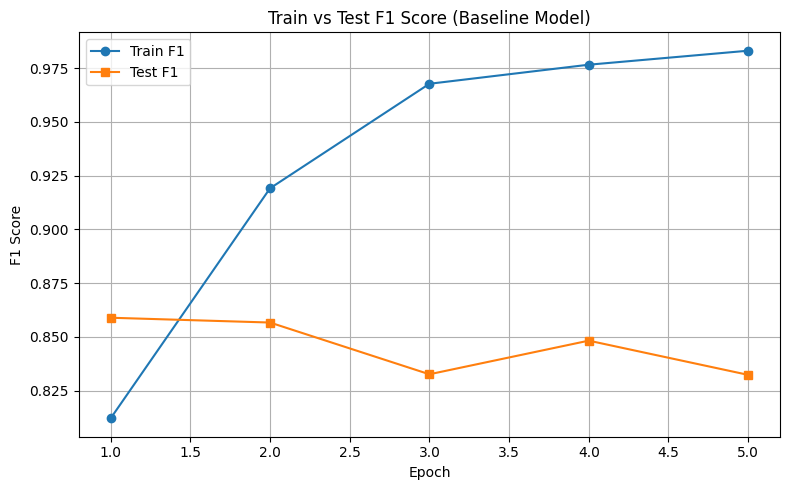

[Enhanced Model] Epoch 1: Train F1=0.8693 | Test F1=0.8469
[Enhanced Model] Epoch 2: Train F1=0.9610 | Test F1=0.8469
[Enhanced Model] Epoch 3: Train F1=0.9833 | Test F1=0.8374
[Enhanced Model] Epoch 4: Train F1=0.9836 | Test F1=0.8415
[Enhanced Model] Epoch 5: Train F1=0.9844 | Test F1=0.8404


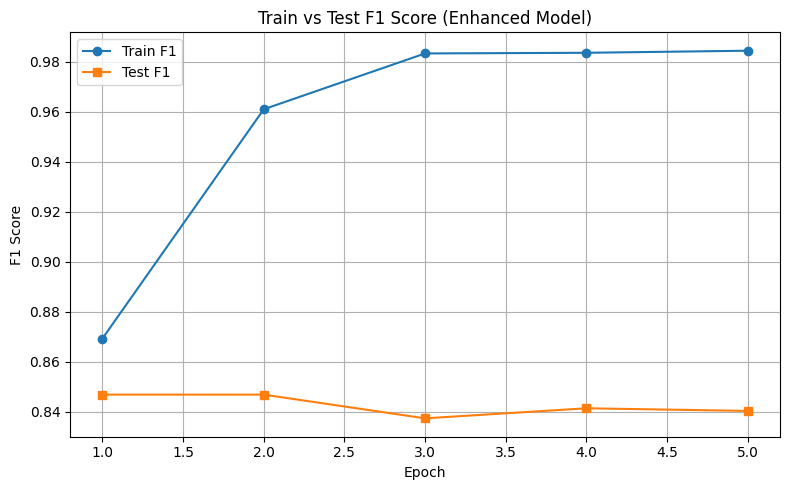

In [15]:
import torch
import torch.nn as nn
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

def train_model_with_plot(model, train_loader, test_loader, epochs=10, label="Model"):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    train_f1_scores = []
    test_f1_scores = []

    for epoch in range(epochs):
        model.train()
        train_preds, train_labels = [], []
        for inputs, explicit, labels, _ in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs, explicit) if hasattr(model, 'explicit_mlp') else model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_preds.extend(outputs.argmax(1).cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        train_f1_scores.append(train_f1)

        model.eval()
        test_preds, test_labels = [], []
        with torch.no_grad():
            for inputs, explicit, labels, _ in test_loader:
                outputs = model(inputs, explicit) if hasattr(model, 'explicit_mlp') else model(inputs)
                test_preds.extend(outputs.argmax(1).cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        test_f1 = f1_score(test_labels, test_preds, average='weighted')
        test_f1_scores.append(test_f1)

        print(f"[{label}] Epoch {epoch+1}: Train F1={train_f1:.4f} | Test F1={test_f1:.4f}")

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), train_f1_scores, marker='o', label='Train F1')
    plt.plot(range(1, epochs + 1), test_f1_scores, marker='s', label='Test F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title(f'Train vs Test F1 Score ({label})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call for both models with labels
train_model_with_plot(baseline_model, train_loader, val_loader, epochs=5, label="Baseline Model")
train_model_with_plot(enhanced_model, train_loader, val_loader, epochs=5, label="Enhanced Model")


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def compare_attention(models, model_names, text, tokenizer, word2idx):
    tokens = tokenizer(text)
    input_ids = [word2idx.get(w, word2idx["<unk>"]) for w in tokens]
    padded_ids = input_ids[:32] + [word2idx["<pad>"]] * (32 - len(input_ids))
    input_tensor = torch.tensor([padded_ids])
    
    explicit_features = extract_explicit_features(text)
    explicit_tensor = torch.tensor([[
        explicit_features['incongruities'],
        explicit_features['positive_words'],
        explicit_features['negative_words'],
        explicit_features['longest_positive'],
        explicit_features['lexical_polarity']
    ]], dtype=torch.float32)
    
    fig, axes = plt.subplots(1, len(models), figsize=(15, 3))
    if len(models) == 1:
        axes = [axes]
    
    for i, (model, name) in enumerate(zip(models, model_names)):
        model.eval()
        with torch.no_grad():
            if hasattr(model, 'explicit_mlp'):
                _, attention = model(input_tensor, explicit_tensor, return_attention=True)
            else:
                _, attention = model(input_tensor, return_attention=True)
        
        attention = attention.squeeze().cpu().numpy()[:len(tokens)]
        
        sns.heatmap([attention], annot=[tokens], fmt='', 
                   cmap='YlOrRd', ax=axes[i], cbar=False)
        axes[i].set_title(f'{name} Attention')
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    
    plt.tight_layout()
    plt.show()

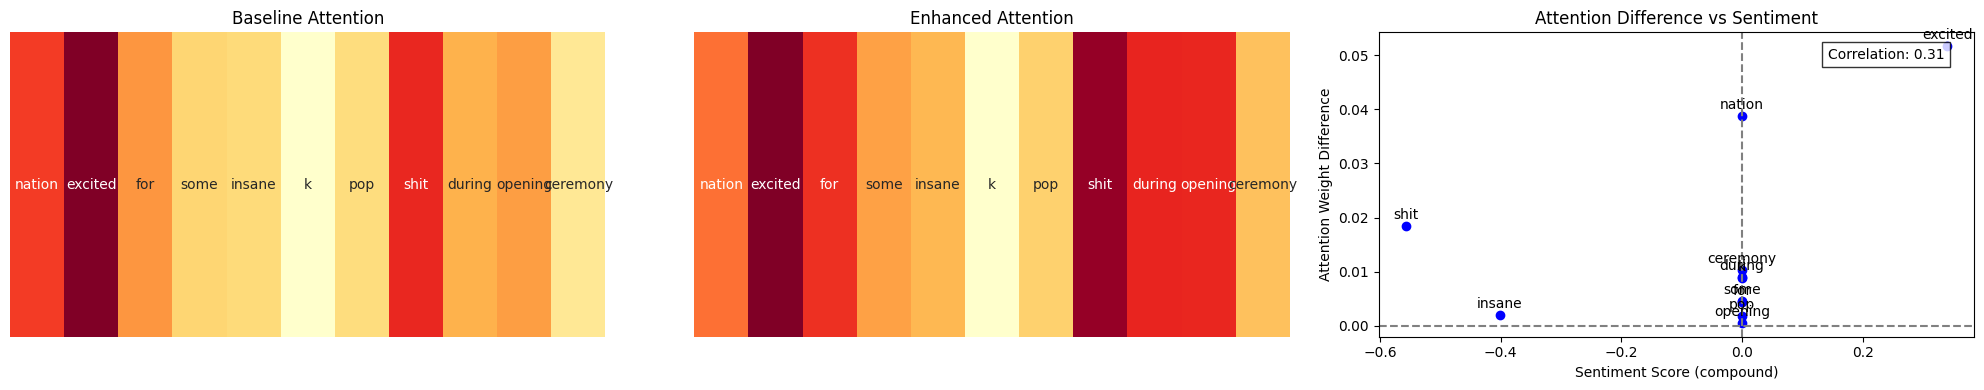


Attention Difference Analysis:
Correlation between sentiment magnitude and attention difference: 0.31
Strong positive correlation - Words with more extreme sentiment show larger attention differences

Words with largest attention differences:
'excited': Sentiment=0.34, ΔAttention=0.0517
'nation': Sentiment=0.00, ΔAttention=0.0388
'shit': Sentiment=-0.56, ΔAttention=0.0185


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_attention(models, model_names, text, tokenizer, word2idx):
    tokens = tokenizer(text)
    input_ids = [word2idx.get(w, word2idx["<unk>"]) for w in tokens]
    padded_ids = input_ids[:32] + [word2idx["<pad>"]] * (32 - len(input_ids))
    input_tensor = torch.tensor([padded_ids])
    
    # Get sentiment scores for each word
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = [sid.polarity_scores(word)['compound'] for word in tokens]
    
    explicit_features = extract_explicit_features(text)
    explicit_tensor = torch.tensor([[
        explicit_features['incongruities'],
        explicit_features['positive_words'],
        explicit_features['negative_words'],
        explicit_features['longest_positive'],
        explicit_features['lexical_polarity']
    ]], dtype=torch.float32)
    
    # Get attention weights from both models
    attentions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            if hasattr(model, 'explicit_mlp'):
                _, attention = model(input_tensor, explicit_tensor, return_attention=True)
            else:
                _, attention = model(input_tensor, return_attention=True)
        attentions.append(attention.squeeze().cpu().numpy()[:len(tokens)])
    
    # Calculate attention differences
    attention_diff = np.abs(attentions[1] - attentions[0])  # Enhanced - Baseline
    
    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
    
    # Plot 1: Both models' attention
    sns.heatmap([attentions[0]], annot=[tokens], fmt='', cmap='YlOrRd', ax=ax1, cbar=False)
    ax1.set_title(f'{model_names[0]} Attention')
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    sns.heatmap([attentions[1]], annot=[tokens], fmt='', cmap='YlOrRd', ax=ax2, cbar=False)
    ax2.set_title(f'{model_names[1]} Attention')
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # Plot 2: Attention differences vs sentiment
    ax3.scatter(sentiment_scores, attention_diff, color='blue')
    
    # Annotate each point with the word
    for i, word in enumerate(tokens):
        ax3.annotate(word, (sentiment_scores[i], attention_diff[i]), 
                    textcoords="offset points", xytext=(0,5), ha='center')
    
    ax3.set_xlabel('Sentiment Score (compound)')
    ax3.set_ylabel('Attention Weight Difference')
    ax3.set_title('Attention Difference vs Sentiment')
    ax3.axhline(y=0, color='gray', linestyle='--')
    ax3.axvline(x=0, color='gray', linestyle='--')
    
    # Calculate and display correlation
    correlation = np.corrcoef(np.abs(sentiment_scores), attention_diff)[0, 1]
    ax3.text(0.95, 0.95, f'Correlation: {correlation:.2f}', 
             transform=ax3.transAxes, ha='right', va='top',
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print("\nAttention Difference Analysis:")
    print(f"Correlation between sentiment magnitude and attention difference: {correlation:.2f}")
    if correlation > 0.3:
        print("Strong positive correlation - Words with more extreme sentiment show larger attention differences")
    elif correlation < -0.3:
        print("Strong negative correlation - Words with more neutral sentiment show larger attention differences")
    else:
        print("Weak correlation - No clear relationship between sentiment and attention differences")
    
    # Show top words contributing to differences
    diff_indices = np.argsort(attention_diff)[::-1][:3]  # Top 3 differences
    print("\nWords with largest attention differences:")
    for idx in diff_indices:
        print(f"'{tokens[idx]}': Sentiment={sentiment_scores[idx]:.2f}, ΔAttention={attention_diff[idx]:.4f}")

# Example usage:
test_sentence = "nation excited for some insane k-pop shit during opening ceremony"
compare_attention(
    [baseline_model, enhanced_model], 
    ["Baseline", "Enhanced"],
    test_sentence,
    simple_tokenizer,
    word2idx
)

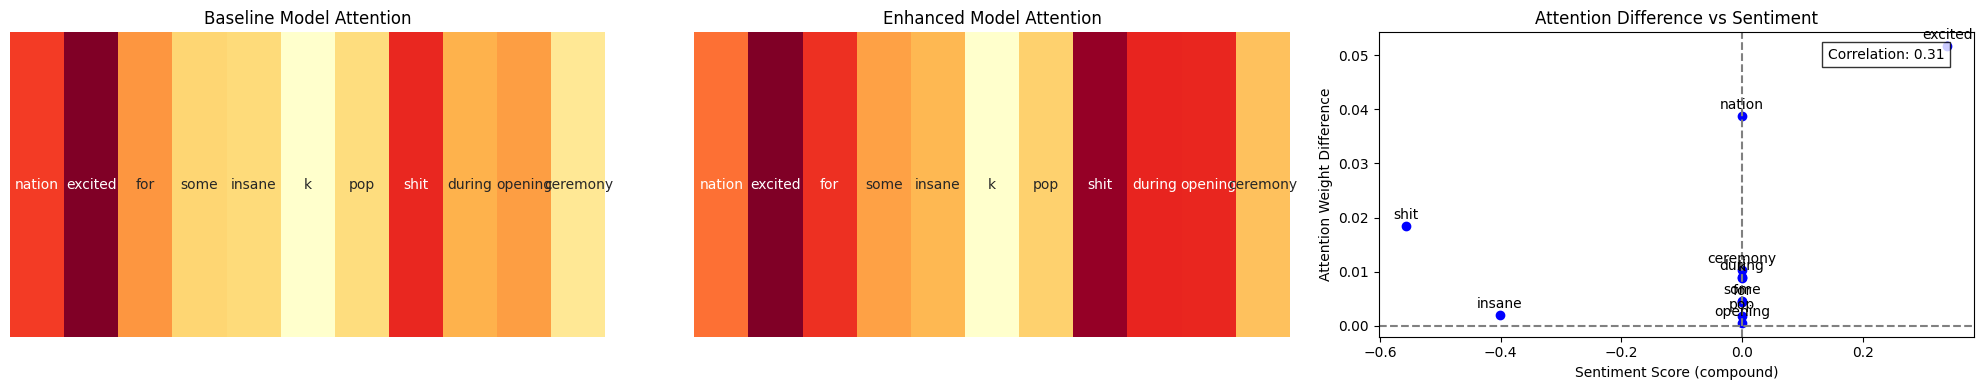


Attention Difference Analysis:
Correlation between sentiment magnitude and attention difference: 0.31
Strong positive correlation - Words with more extreme sentiment show larger attention differences

Words with largest attention differences:
'excited': Sentiment=0.34, ΔAttention=0.0517
'nation': Sentiment=0.00, ΔAttention=0.0388
'shit': Sentiment=-0.56, ΔAttention=0.0185


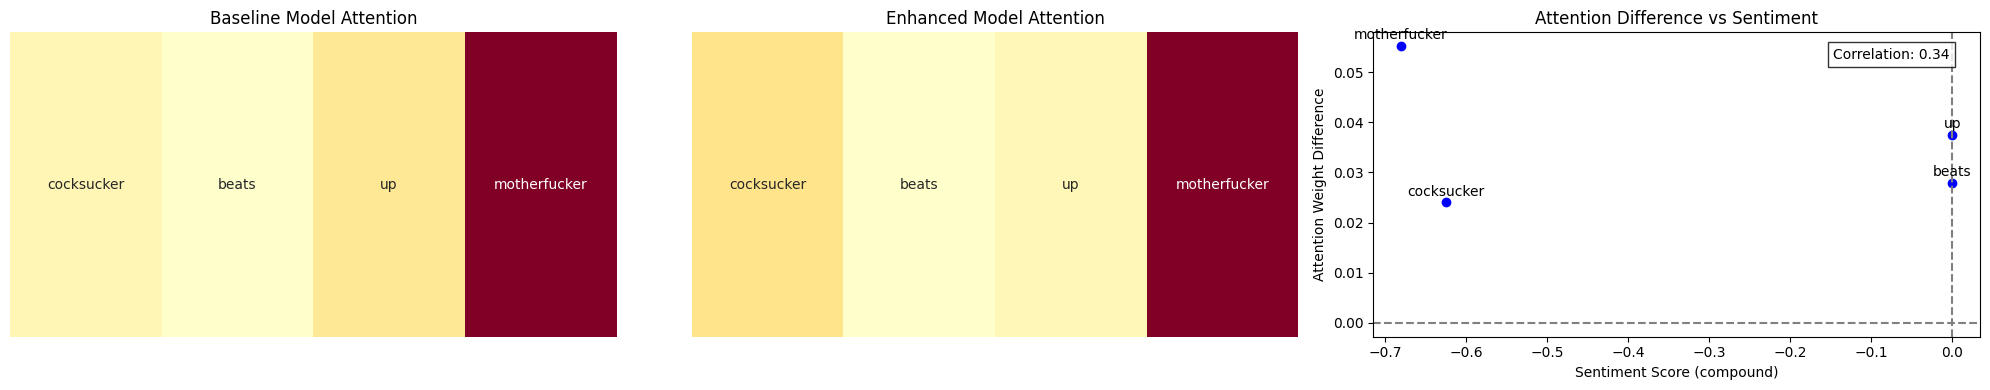


Attention Difference Analysis:
Correlation between sentiment magnitude and attention difference: 0.34
Strong positive correlation - Words with more extreme sentiment show larger attention differences

Words with largest attention differences:
'motherfucker': Sentiment=-0.68, ΔAttention=0.0552
'up': Sentiment=0.00, ΔAttention=0.0374
'beats': Sentiment=0.00, ΔAttention=0.0280


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


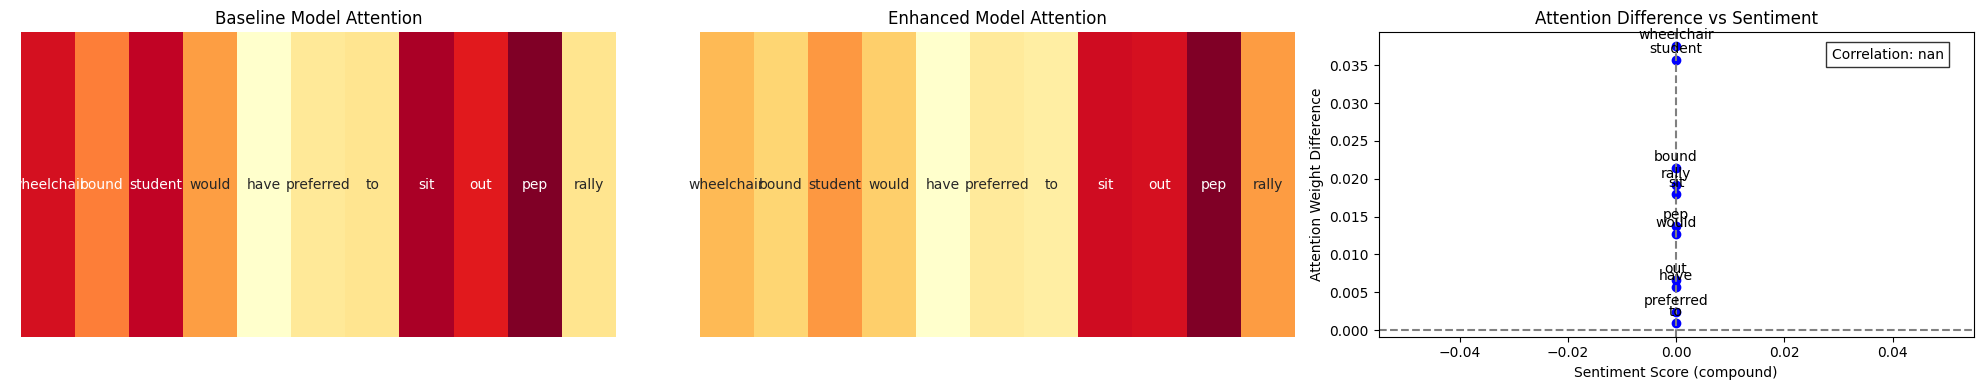


Attention Difference Analysis:
Correlation between sentiment magnitude and attention difference: nan
Weak correlation - No clear relationship between sentiment and attention differences

Words with largest attention differences:
'wheelchair': Sentiment=0.00, ΔAttention=0.0375
'student': Sentiment=0.00, ΔAttention=0.0357
'bound': Sentiment=0.00, ΔAttention=0.0214


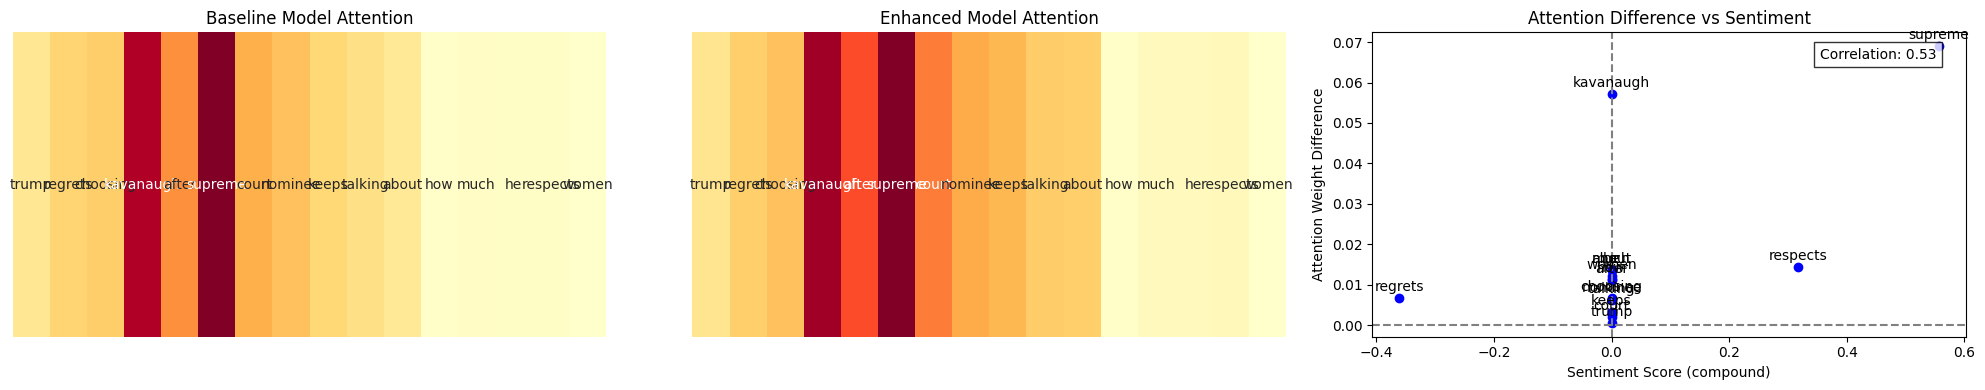


Attention Difference Analysis:
Correlation between sentiment magnitude and attention difference: 0.53
Strong positive correlation - Words with more extreme sentiment show larger attention differences

Words with largest attention differences:
'supreme': Sentiment=0.56, ΔAttention=0.0690
'kavanaugh': Sentiment=0.00, ΔAttention=0.0572
'respects': Sentiment=0.32, ΔAttention=0.0143


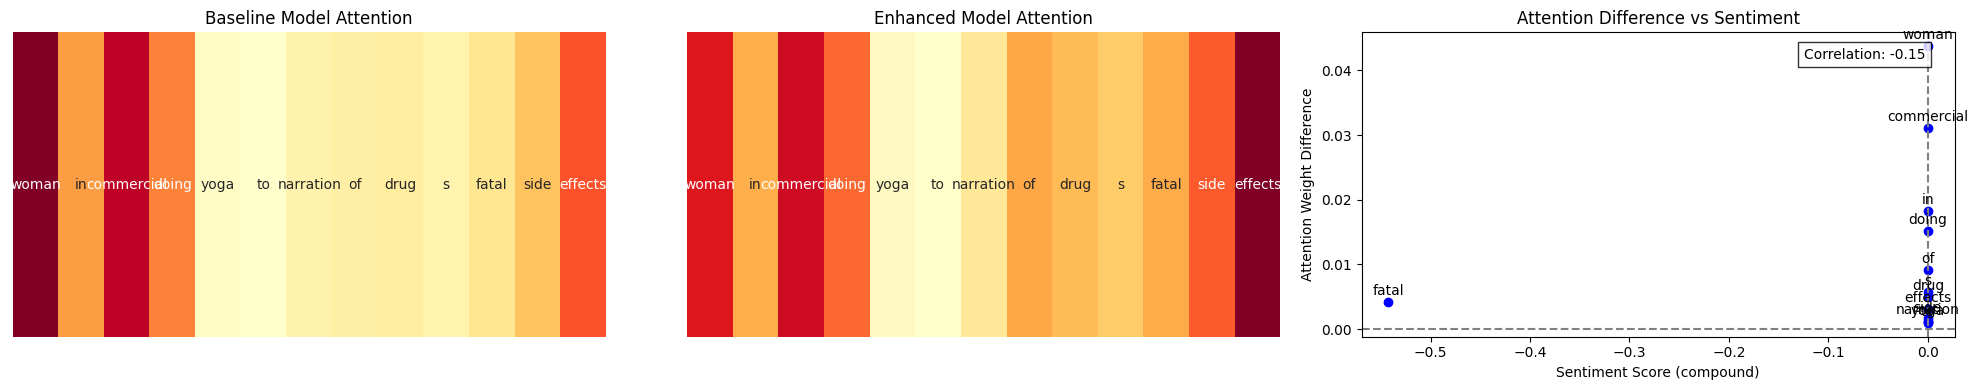


Attention Difference Analysis:
Correlation between sentiment magnitude and attention difference: -0.15
Weak correlation - No clear relationship between sentiment and attention differences

Words with largest attention differences:
'woman': Sentiment=0.00, ΔAttention=0.0437
'commercial': Sentiment=0.00, ΔAttention=0.0311
'in': Sentiment=0.00, ΔAttention=0.0182


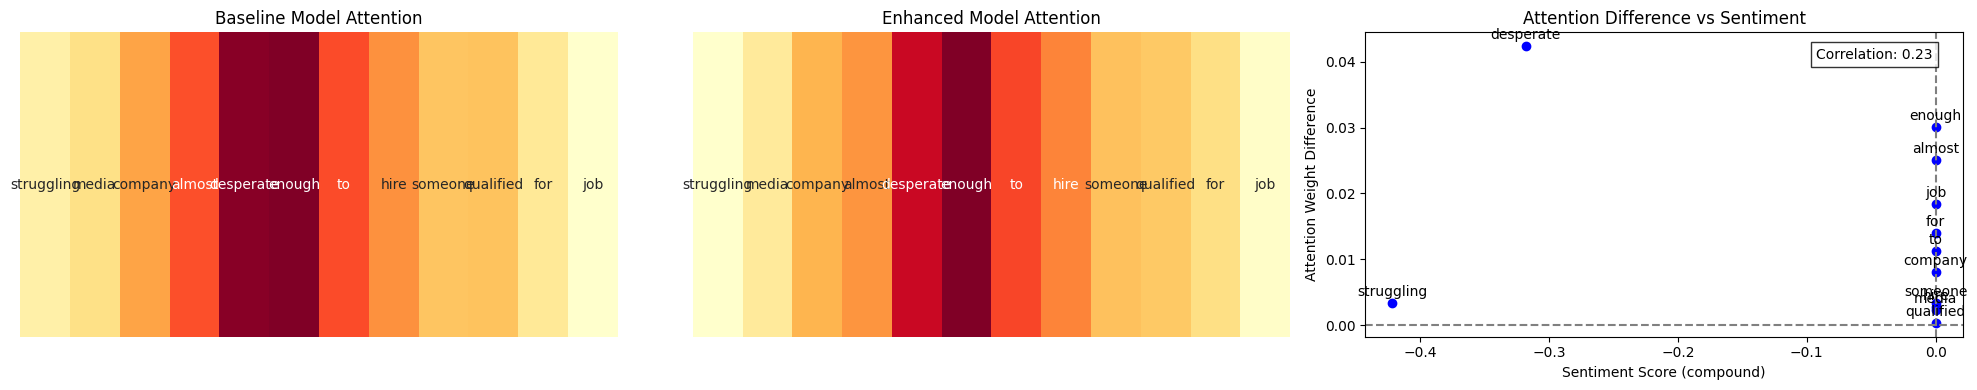


Attention Difference Analysis:
Correlation between sentiment magnitude and attention difference: 0.23
Weak correlation - No clear relationship between sentiment and attention differences

Words with largest attention differences:
'desperate': Sentiment=-0.32, ΔAttention=0.0424
'enough': Sentiment=0.00, ΔAttention=0.0302
'almost': Sentiment=0.00, ΔAttention=0.0250


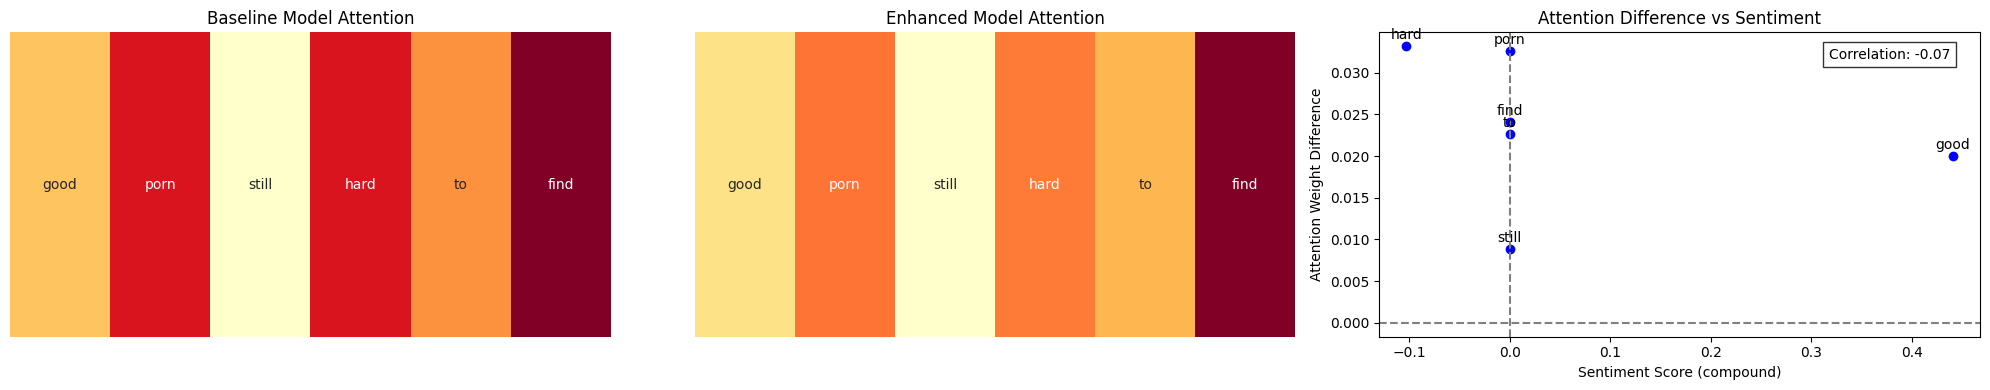


Attention Difference Analysis:
Correlation between sentiment magnitude and attention difference: -0.07
Weak correlation - No clear relationship between sentiment and attention differences

Words with largest attention differences:
'hard': Sentiment=-0.10, ΔAttention=0.0332
'porn': Sentiment=0.00, ΔAttention=0.0326
'find': Sentiment=0.00, ΔAttention=0.0241


In [18]:
test_sentences = ["nation excited for some insane k-pop shit during opening ceremony",
                  "cocksucker beats up motherfucker",
                  "wheelchair-bound student would have preferred to sit out pep rally",
                  "trump regrets choosing kavanaugh after supreme court nominee keeps talking about how much he respects women",
                  "woman in commercial doing yoga to narration of drug's fatal side effects",
                  "struggling media company almost desperate enough to hire someone qualified for job",
                  "good porn still hard to find"
                 ]
for test_sentence in test_sentences:
    compare_attention(
        [baseline_model, enhanced_model],
        ["Baseline Model", "Enhanced Model"],
        test_sentence,
        simple_tokenizer,
        word2idx
    )

In [19]:
text = "nation excited for some insane k-pop shit during opening ceremony"
tokens, attention, explicit_features = visualize_attention(model, simple_tokenizer, text, word2idx)
plot_attention_with_incongruity(tokens, attention, explicit_features)

NameError: name 'visualize_attention' is not defined